# Looked After Children (LAC) LSOA Analysis


# Importing Necessary Libraries

In [1]:
#import bigquery
from google.cloud import bigquery
from google.cloud import bigquery_storage
 
#other needed libraries
import os
import pandas as pd
import numpy as np
import pandas_gbq
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import json
import geopandas as gpd
import mapclassify
import folium
from scipy import stats
import contextily as ctx
import libpysal
from pysal.explore import esda
from esda.moran import Moran, Moran_Local
from libpysal.weights import Queen, Rook
from splot.esda import plot_local_autocorrelation, lisa_cluster
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

plt.style.use('tableau-colorblind10')
color='#702A7D'

/opt/conda/lib/python3.10/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/jupyter/.config/gcloud/application_default_credentials.json"

#Instatiate BigQuery Client
client = bigquery.Client()

# Define Query to Get Data

In [3]:
query = """
WITH lac_WithAddress AS (
  SELECT
    lac.person_id,
    lac.StartDate,
    lac.EndDate,
    lac.EthnicOrigin,
    p.birth_datetime AS DateOfBirth,
    a.partialPostcode AS PCArea,
    a.SOA AS LSOA,
    /* For each lac row, rank the joined address rows 
       (if any) by DateEventRecorded (converted to DATE) descending */
       
    ROW_NUMBER() OVER (
      PARTITION BY lac.person_id, lac.StartDate
      ORDER BY DATE(a.DateEvent) DESC
    ) AS rn
  FROM
    `yhcr-prd-bradfor-bia-core.CB_2649.cb_bmbc_ChildrensSocialServices_CiC` lac
  LEFT JOIN
    `yhcr-prd-bradfor-bia-core.CB_2649.tbl_AddressHistory_New` a
      ON lac.person_id = a.person_id
      AND DATE(a.DateEvent) <= lac.StartDate
  LEFT JOIN
    `yhcr-prd-bradfor-bia-core.CB_2649.person` p
      ON lac.person_id = p.person_id
)
SELECT 
  person_id,
  PCArea,       
  StartDate,
  EndDate,
  EthnicOrigin,
  DateOfBirth,
  LSOA
FROM
  lac_WithAddress
WHERE 
  rn = 1;
"""

# Load Query into Pandas Dataframe

In [4]:
cic = pandas_gbq.read_gbq(query)

Downloading: 100%|██████████|


In [5]:
# Information about the columns
cic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   person_id     1917 non-null   object             
 1   PCArea        1759 non-null   object             
 2   StartDate     1917 non-null   dbdate             
 3   EndDate       961 non-null    dbdate             
 4   EthnicOrigin  1917 non-null   object             
 5   DateOfBirth   1911 non-null   datetime64[us, UTC]
 6   LSOA          1333 non-null   object             
dtypes: datetime64[us, UTC](1), dbdate(2), object(4)
memory usage: 105.0+ KB


In [6]:
# Count number of missing values
missing_values = cic.isnull().sum()
total_values = cic.shape[0]
percentage_missing = round(missing_values/total_values*100, 2)
percentage_missing

person_id        0.00
PCArea           8.24
StartDate        0.00
EndDate         49.87
EthnicOrigin     0.00
DateOfBirth      0.31
LSOA            30.46
dtype: float64

In [7]:
# Strip whitespace from all string/object columns
cic = cic.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Load Bradford Children Population Data 0-17 years, 2021.
source: https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/lowersuperoutputareamidyearpopulationestimates

In [8]:
population_data_file_path = '../data/Bradford_Children_population_0-17_2021.csv'
population_data = pd.read_csv(population_data_file_path)
population_data.columns

Index(['LAD 2021 Code', 'LAD 2021 Name', 'LSOA 2021 Code', 'LSOA 2021 Name',
       'TotalPop', 'FemalePop', 'MalePop'],
      dtype='object')

# Load Bradford Boundary Data
source: https://borders.ukdataservice.ac.uk/

In [9]:
boundary_data_filepath = "../data/BradfordBoundaryData/england_lsoa_2021.shp"
bradord_boundary_data = gpd.read_file(boundary_data_filepath)

# Print data type and crs
print(type(bradord_boundary_data))
print(bradord_boundary_data.crs)
print(bradord_boundary_data.columns)

<class 'geopandas.geodataframe.GeoDataFrame'>
EPSG:27700
Index(['lsoa21cd', 'lsoa21nm', 'label', 'name', 'geometry'], dtype='object')


# Load Index of Multiple Deprivation (IMD) Data
source: https://data.cdrc.ac.uk/dataset/index-multiple-deprivation-imd

In [10]:
imd_filepath = "../data/English IMD 2019/IMD_2019.shp"
imd = gpd.read_file(imd_filepath)

In [11]:
# Display the columns in the IMD data
imd.columns

Index(['lsoa11cd', 'lsoa11nm', 'lsoa11nmw', 'st_areasha', 'st_lengths',
       'IMD_Rank', 'IMD_Decile', 'LSOA01NM', 'LADcd', 'LADnm', 'IMDScore',
       'IMDRank0', 'IMDDec0', 'IncScore', 'IncRank', 'IncDec', 'EmpScore',
       'EmpRank', 'EmpDec', 'EduScore', 'EduRank', 'EduDec', 'HDDScore',
       'HDDRank', 'HDDDec', 'CriScore', 'CriRank', 'CriDec', 'BHSScore',
       'BHSRank', 'BHSDec', 'EnvScore', 'EnvRank', 'EnvDec', 'IDCScore',
       'IDCRank', 'IDCDec', 'IDOScore', 'IDORank', 'IDODec', 'CYPScore',
       'CYPRank', 'CYPDec', 'ASScore', 'ASRank', 'ASDec', 'GBScore', 'GBRank',
       'GBDec', 'WBScore', 'WBRank', 'WBDec', 'IndScore', 'IndRank', 'IndDec',
       'OutScore', 'OutRank', 'OutDec', 'TotPop', 'DepChi', 'Pop16_59',
       'Pop60+', 'WorkPop', 'geometry'],
      dtype='object')

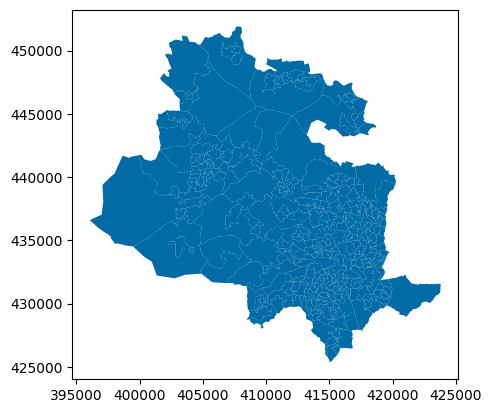

In [12]:
# Display the map

bradord_boundary_data.plot();

In [13]:
# Drop rows where LSOA is missing
cic = cic.dropna(subset=['LSOA'])
cic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1333 entries, 1 to 1916
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   person_id     1333 non-null   object             
 1   PCArea        1332 non-null   object             
 2   StartDate     1333 non-null   dbdate             
 3   EndDate       658 non-null    dbdate             
 4   EthnicOrigin  1333 non-null   object             
 5   DateOfBirth   1333 non-null   datetime64[us, UTC]
 6   LSOA          1333 non-null   object             
dtypes: datetime64[us, UTC](1), dbdate(2), object(4)
memory usage: 83.3+ KB


In [14]:
# Example of unique LSOA prefixes
cic['lsoa_prefix'] = cic['LSOA'].str[:3]
print(cic['lsoa_prefix'].unique())

['E01' '' 'S01' 'W01']


In [15]:
# Filter cic to keep only English LSOAs (starting with 'E01') and remove empty strings
cic_english_lsoa = cic[cic['LSOA'].str.startswith('E01', na=False)].copy()

print(f"Number of rows in cic before filtering: {len(cic)}")
print(f"Number of rows in cic_english_lsoa after filtering: {len(cic_english_lsoa)}")

Number of rows in cic before filtering: 1333
Number of rows in cic_english_lsoa after filtering: 1160


# Merge intervention and boundary data

In [16]:
# 1. Check for missing matches before merging
print("Bradford boundary unique LSOAs:", len(bradord_boundary_data['lsoa21cd'].unique()))
print("CIC English unique LSOAs:", len(cic_english_lsoa['LSOA'].unique()))
print("Common LSOAs:", len(set(bradord_boundary_data['lsoa21cd']).intersection(set(cic_english_lsoa['LSOA']))))

# 2. Use left merge to preserve geometry
merged_data = bradord_boundary_data.merge(
    cic_english_lsoa,
    left_on='lsoa21cd',
    right_on='LSOA',
    how='left',
)

# 3. Verify geometry column is preserved
print("Geometry column present:", 'geometry' in merged_data.columns)
print(merged_data.crs)

Bradford boundary unique LSOAs: 312
CIC English unique LSOAs: 398
Common LSOAs: 227
Geometry column present: True
EPSG:27700


<Axes: >

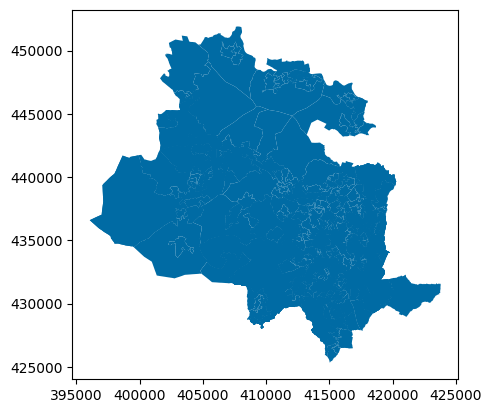

In [17]:
# Confirm the map plot
merged_data.plot()

In [18]:
merged_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   lsoa21cd      992 non-null    object             
 1   lsoa21nm      992 non-null    object             
 2   label         992 non-null    object             
 3   name          992 non-null    object             
 4   geometry      992 non-null    geometry           
 5   person_id     907 non-null    object             
 6   PCArea        907 non-null    object             
 7   StartDate     907 non-null    dbdate             
 8   EndDate       474 non-null    dbdate             
 9   EthnicOrigin  907 non-null    object             
 10  DateOfBirth   907 non-null    datetime64[us, UTC]
 11  LSOA          907 non-null    object             
 12  lsoa_prefix   907 non-null    object             
dtypes: datetime64[us, UTC](1), dbdate(2), geometry(1), object

In [19]:
# Drop unwanted columns
columns_to_drop = ['lsoa21nm', 'label', 'LSOA']
merged_data.drop(columns=columns_to_drop, inplace=True)

In [20]:
# Convert dates data types and ensure they are timezone-aware in UTC
dates_columns = ['StartDate', 'EndDate', 'DateOfBirth']
merged_data[dates_columns] = merged_data[dates_columns].apply(pd.to_datetime)

# Convert to timezone-aware datetime objects in UTC
merged_data['StartDate'] = merged_data['StartDate'].dt.tz_localize('UTC')
merged_data['EndDate'] = merged_data['EndDate'].dt.tz_localize('UTC')
merged_data['DateOfBirth'] = merged_data['DateOfBirth'].astype('datetime64[ns, UTC]')

In [21]:
merged_data.dtypes

lsoa21cd                     object
name                         object
geometry                   geometry
person_id                    object
PCArea                       object
StartDate       datetime64[ns, UTC]
EndDate         datetime64[ns, UTC]
EthnicOrigin                 object
DateOfBirth     datetime64[ns, UTC]
lsoa_prefix                  object
dtype: object

In [22]:
# Creating New Columns

# Number of Days in Intervention
merged_data['num_of_days_in_intervention'] = (merged_data['EndDate'] - merged_data['StartDate']).dt.days

# Age at Entry
seconds_in_year = 365.25 * 24 * 3600

age_series = ((merged_data['StartDate'] - merged_data['DateOfBirth'])
              .dt.total_seconds() / seconds_in_year).round()

# Convert to numeric explicitly, then cast to Pandas nullable int type ('Int64')
merged_data['age_at_entry'] = pd.to_numeric(age_series, errors='coerce').astype('Int64')

# Age Binning
bins = [0, 1, 4, 9, 15, 16]
labels = ['Under 1', '1-4', '5-9', '10-15', '16+']
merged_data['entry_agegroup'] = pd.cut(merged_data['age_at_entry'], 
                             bins=bins, 
                             labels=labels,
                             right=True)

#### Number of LAC per LSOA - Is there a significant variation in number of LAC across LSOAs

In [23]:
# Group by LSOA and count the number of children
children_per_lsoa = merged_data.groupby('lsoa21cd', as_index=False).agg(
    children_count=('lsoa21cd', 'size'),
    geometry=('geometry', 'first')
).pipe(gpd.GeoDataFrame)

# Merge with IMD Data
columns_to_include_from_imd = [
    'lsoa11cd', 'IMD_Decile', 'IMDScore',
    'IDCDec', 'CYPDec', 'IncDec', 'EmpDec',
    'EduDec', 'CriDec', 'BHSDec', 'EnvDec',
    'HDDDec', 'DepChi'
]

children_per_lsoa = children_per_lsoa.merge(
    imd[columns_to_include_from_imd],
    left_on ='lsoa21cd',
    right_on='lsoa11cd',
    how='left'
).drop(columns='lsoa11cd')

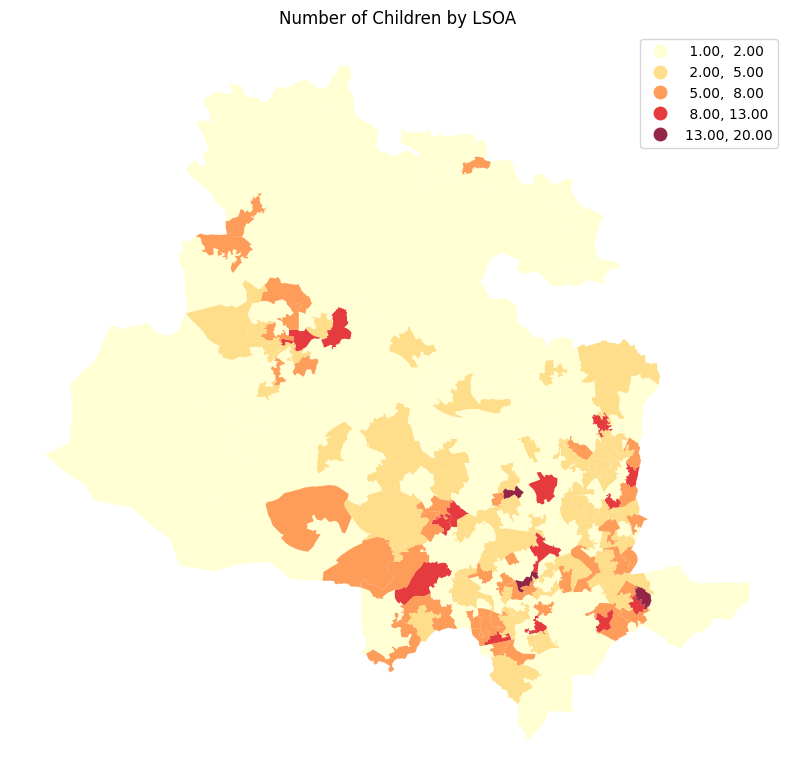

In [24]:
# Step 3: Plot the data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111) 

children_per_lsoa.plot(
    ax=ax,                  
    column='children_count',
    scheme='FisherJenks',     
    cmap='YlOrRd',
    alpha=0.85,
    legend=True,            
)

# Remove axis for better visualization
ax.set_axis_off()

# Add a title
ax.set_title("Number of Children by LSOA")

# Show the plot
plt.show()

### LAC Population Rate  by LSOA - Looking at rate helps us balance uneven population across LSOAs

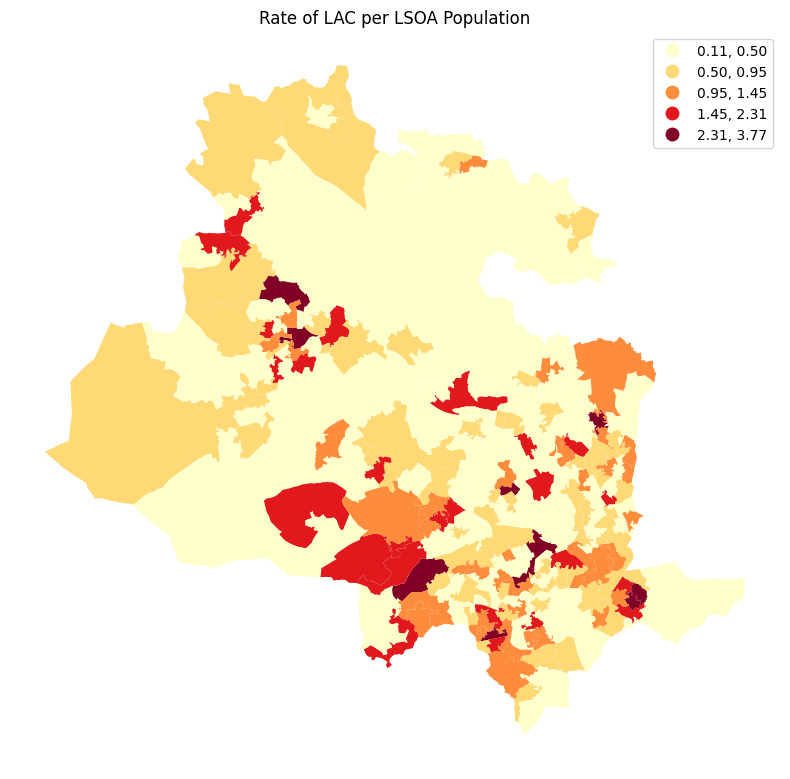

In [25]:
# Merge with population data
children_population = children_per_lsoa.merge(
    population_data[['LSOA 2021 Code', 'TotalPop']],
    left_on='lsoa21cd',
    right_on='LSOA 2021 Code',
    how='left'
).drop(columns='LSOA 2021 Code')

# Calculate children proportion
children_population['children_per_total_pop'] = (
    children_population['children_count'] /
    children_population['TotalPop']) * 100
# Create a figure
fig, ax = plt.subplots(figsize=(8, 8))
# Plot the LAC rate
children_population.plot(
    ax=ax,
    column='children_per_total_pop',
    scheme='NaturalBreaks',
    cmap='YlOrRd',
    legend=True
)
ax.set_axis_off()
ax.set_title('Rate of LAC per LSOA Population')
plt.tight_layout()
plt.savefig("../figs/pop_rate_imd_decile.png", dpi=300)
plt.show()

### Global Spatial Autocorrelation for LAC Population Rate Using Moran I and Getis-Ord G
* Moran's I asks: "Are similar values near each other?"
* Getis-Ord G asks: "Are high values clustering together, or are low values clustering together?"

In [26]:
from libpysal.weights import KNN
w_queen = Queen.from_dataframe(children_population)
w_queen.transform = 'r' 

# Calculate Moran's I
moran_queen = Moran(children_population['children_per_total_pop'], w_queen)
print("Queen: \n")
print(f"Moran's I: {moran_queen.I}")
print(f"p-value: {moran_queen.p_sim}")
print(f"z-score: {moran_queen.z_sim}")

# KNN 
centroids = children_population.geometry.centroid
coords = list(zip(centroids.x, centroids.y))
w_knn = KNN(coords, k=6)
w_knn.transform = 'r'

moran_knn = Moran(children_population['children_per_total_pop'], w_knn)
print("KNN: \n")
print(f"Moran's I: {moran_knn.I}")
print(f"p-value: {moran_knn.p_sim}")
print(f"z-score: {moran_knn.z_sim}")

Queen: 

Moran's I: 0.11414647793575633
p-value: 0.003
z-score: 3.328866804660788
KNN: 

Moran's I: 0.09108311854960001
p-value: 0.003
z-score: 2.9104921576263565


In [27]:
# Calculate Getis-Ord G
# Queen weights matrix
print("Getis-Ord G, Queen Weights")
g = esda.getisord.G(children_population['children_per_total_pop'], w_queen)
print(f"Getis-Ord G: {g.G}")
print(f"p-value: {g.p_sim}")
print(f"z-score: {g.z_sim}")

# KNN
print("\nGetis-Ord G, KNN Weights")
g = esda.getisord.G(children_population['children_per_total_pop'], w_knn)
print(f"Getis-Ord G: {g.G}")
print(f"p-value: {g.p_sim}")
print(f"z-score: {g.z_sim}")

Getis-Ord G, Queen Weights
Getis-Ord G: 0.020106281602411423
p-value: 0.008
z-score: 2.675901757650453

Getis-Ord G, KNN Weights
Getis-Ord G: 0.020761309047575973
p-value: 0.007
z-score: 2.6867555270322425


___________
Low Moran I's score suggest spatial randomness. No spatial autocorrelation.<br>
Getis-Ord G: The results shows there are hig value clusters (hot spots) with a confidence level of 96.6%

### Local Autocorrelation with Getis-Ord Gi* and Local Indicators of Spatial Association (LISA)

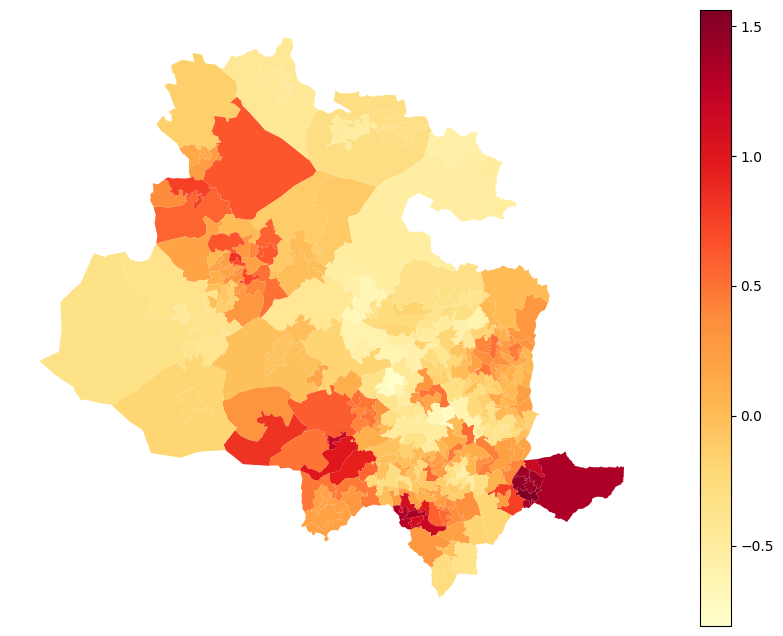

In [28]:
# Hostspot analysis Getis-Ord Gi*
from esda.getisord import G_Local

gi = G_Local(children_population['children_per_total_pop'], w_knn, star=True)
children_population['gi_Zscore'] = gi.Zs
children_population.plot(
    column='gi_Zscore', cmap='YlOrRd',
    legend=True,
    figsize=(12,8)
)
plt.axis('off')
plt.show()

In [29]:
merged_data.columns

Index(['lsoa21cd', 'name', 'geometry', 'person_id', 'PCArea', 'StartDate',
       'EndDate', 'EthnicOrigin', 'DateOfBirth', 'lsoa_prefix',
       'num_of_days_in_intervention', 'age_at_entry', 'entry_agegroup'],
      dtype='object')

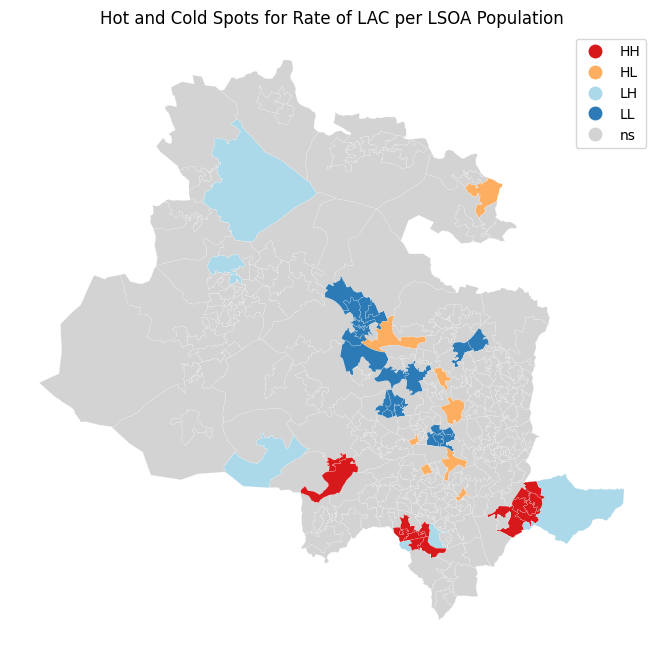

In [30]:
from splot.esda import lisa_cluster
# Local Moran I
lisa = Moran_Local(children_population['children_per_total_pop'], w_knn)

# Plot the local autocorrelation; adjust overall figure size as needed
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
lisa_cluster(lisa, children_population, p=0.05, ax=ax)
ax.set_title("Hot and Cold Spots for Rate of LAC per LSOA Population")
plt.savefig("../figs/lac_hot-cold spots.png", dpi=300)
plt.show()

##### What percentage of LSOAs accounts for what percentage of Children in LAC?

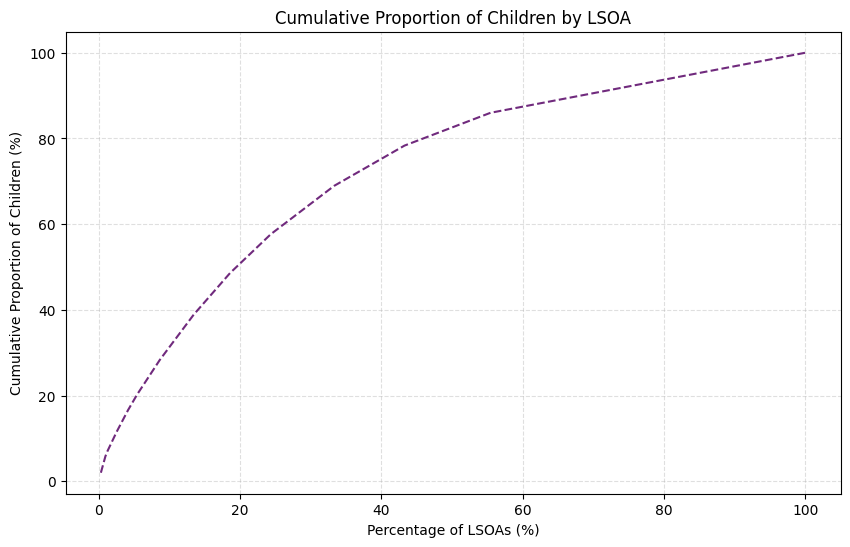

In [31]:
# Number of children
total_children = children_per_lsoa['children_count'].sum()

# Sort by children_count (descending):
children_per_lsoa_sorted = children_per_lsoa.sort_values(by='children_count', ascending=False)

# Calculate the cumulative sum and proportion:
children_per_lsoa_sorted['cumulative_children'] = children_per_lsoa_sorted['children_count'].cumsum()
children_per_lsoa_sorted['cumulative_percent'] = (
    100.0 * children_per_lsoa_sorted['cumulative_children'] / total_children
)

# Create an x-axis representing the percentage of LSOAs.
# Each point's x-value is (index position / total LSOAs) * 100
num_lsoas = len(children_per_lsoa_sorted)
x_percent = [(i + 1) / num_lsoas * 100 for i in range(num_lsoas)]

# Plot cumulative proportion vs. number of LSOAs:
plt.figure(figsize=(10, 6))
plt.plot(
    x_percent,
    children_per_lsoa_sorted['cumulative_percent'],
    linestyle='--',
    color=color
)
plt.title('Cumulative Proportion of Children by LSOA')
plt.xlabel('Percentage of LSOAs (%)')
plt.ylabel('Cumulative Proportion of Children (%)')
plt.grid(True, linestyle='--', alpha=.4)
plt.savefig("../figs/children_proportion_per_LSOAproportion.png", dpi=300)
plt.show()

#### LAC Rate vs. IMD Decile by LSOA -  Is there a relationship btw rate of LAC and the IMD rank of the LSOA = are more LAC in deprived areas?

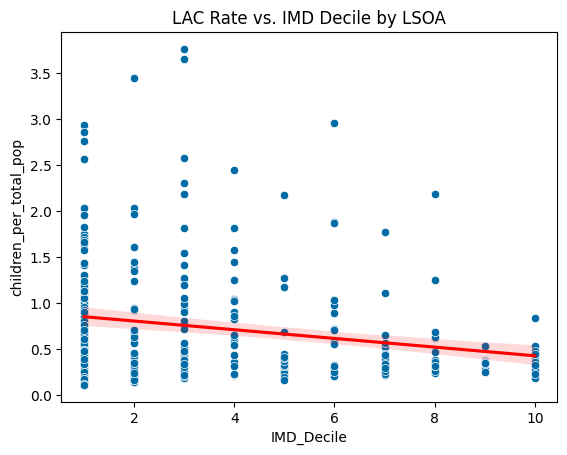

Pearson Correlation: -0.207 (p-value: 2.467e-04)
Spearman Correlation: -0.184 (p-value: 1.200e-03)

Linear Regression Results:
Slope: -0.047227
Intercept: 0.902
R-squared: 0.043
P-value: 2.467e-04


In [32]:
sns.scatterplot(
    data=children_population,
    x='IMD_Decile',
    y='children_per_total_pop'
)

# Add a trendline
sns.regplot(
    data=children_population,
    x='IMD_Decile',
    y='children_per_total_pop',
    scatter=False,
    color='red'
)
plt.title('LAC Rate vs. IMD Decile by LSOA')
plt.savefig("../figs/LAC_Rate_vs.IMD_Decile.png", dpi=300)
plt.show()


# Determine the relationship between IMD Decile and Proportion of LAC 


# Drop rows with NaN
valid = (
    children_population['IMD_Decile'].notna() &
    children_population['children_per_total_pop'].notna()
)
clean_data = children_population[valid]

# Pearson Correlation
correlation, p_value = stats.pearsonr(clean_data['IMD_Decile'], clean_data['children_per_total_pop'])

# Spearman Correlation
spearman_corr, spearman_p = stats.spearmanr(clean_data['IMD_Decile'], clean_data['children_per_total_pop'])

# Linear Regression
slope, intercept, r_value, p_value_reg, std_err = stats.linregress(clean_data['IMD_Decile'], clean_data['children_per_total_pop'])

# Print results
print(f"Pearson Correlation: {correlation:.3f} (p-value: {p_value:.3e})")
print(f"Spearman Correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3e})")
print("\nLinear Regression Results:")
print(f"Slope: {slope:.6f}")
print(f"Intercept: {intercept:.3f}")
print(f"R-squared: {r_value**2:.3f}")
print(f"P-value: {p_value_reg:.3e}")

The downward slope suggest that there's a negative correlation between the rate of LAC per population and the IMD rank.<br>
It appears to be a relationship between deprivation and rate of LAC, where more deprived areas tend to have more number of LAC & higher rates of LAC<br>
Small p-values indicates evidence of association between the variables - not by chance. <br>
Weak correlation coeeficients means that IMD rank is not a strong predictor of the proportion of children.<br>
Negative slope - Less deprived areas have less proportion of LAC<br>
R-squared value implies that only 6% of the variation in LAC rate is explained by the IMD Decile. Hence, other factors plays important roles in explainging the LAC rate per population.

### LAC Rate and IDCScore -  child-specific deprivation measure

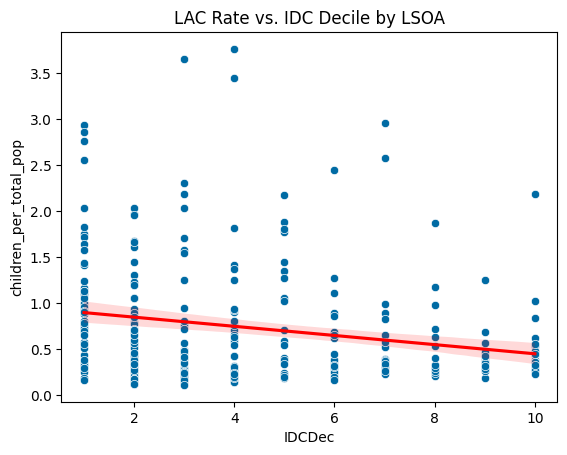

Pearson Correlation: -0.224 (p-value: 7.432e-05)
Spearman Correlation: -0.243 (p-value: 1.668e-05)

Linear Regression Results:
Slope: -0.049790
Intercept: 0.951
R-squared: 0.050
P-value: 7.432e-05


In [33]:
sns.scatterplot(
    data=clean_data,
    x='IDCDec',
    y='children_per_total_pop'
)

# Add a trendline
sns.regplot(
    data=clean_data,
    x='IDCDec',
    y='children_per_total_pop',
    scatter=False,
    color='red'
)
plt.title('LAC Rate vs. IDC Decile by LSOA')
plt.show()

# Determine the relationship between IDCDec and Proportion of LAC 

# Drop rows with NaN
valid = (
    children_population['IDCDec'].notna() &
    children_population['children_per_total_pop'].notna()
)
clean_data = children_population[valid]

# Pearson Correlation
correlation, p_value = stats.pearsonr(clean_data['IDCDec'], clean_data['children_per_total_pop'])

# Spearman Correlation
spearman_corr, spearman_p = stats.spearmanr(clean_data['IDCDec'], clean_data['children_per_total_pop'])

# Linear Regression
slope, intercept, r_value, p_value_reg, std_err = stats.linregress(clean_data['IDCDec'], clean_data['children_per_total_pop'])

# Print results
print(f"Pearson Correlation: {correlation:.3f} (p-value: {p_value:.3e})")
print(f"Spearman Correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3e})")
print("\nLinear Regression Results:")
print(f"Slope: {slope:.6f}")
print(f"Intercept: {intercept:.3f}")
print(f"R-squared: {r_value**2:.3f}")
print(f"P-value: {p_value_reg:.3e}")

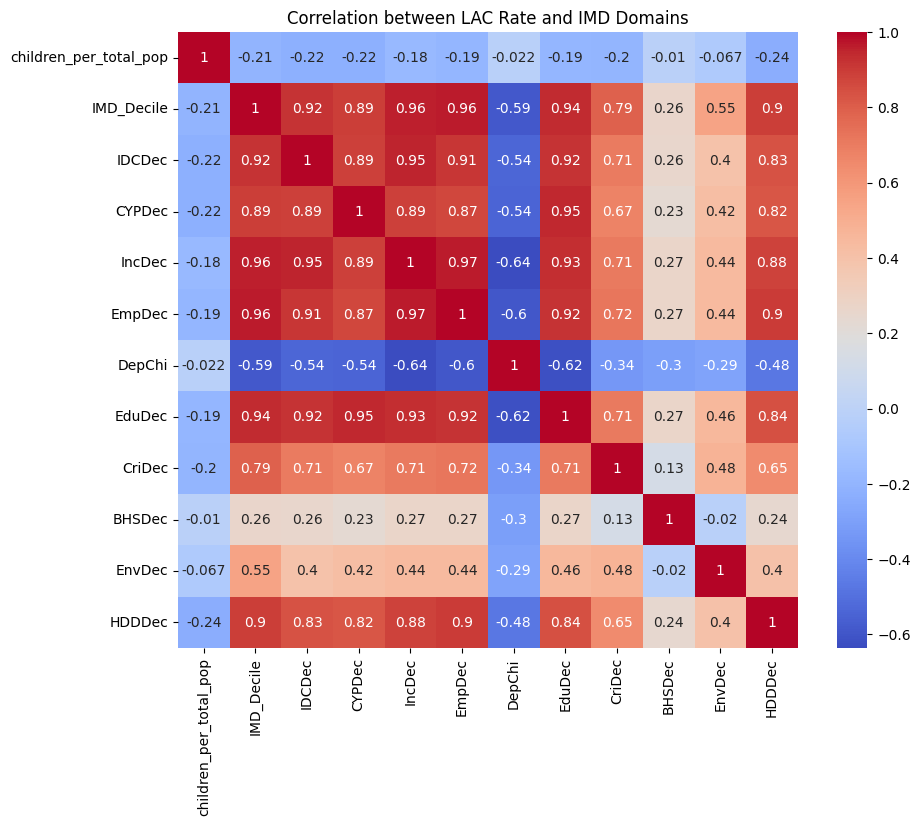

In [34]:
# Correlation Matric for IMD variables and lac rate per lsoa population
corr_matrix = clean_data[[
    'children_per_total_pop', 'IMD_Decile',
    'IDCDec', 'CYPDec', 'IncDec', 'EmpDec', 'DepChi',
    'EduDec', 'CriDec', 'BHSDec', 'EnvDec', 'HDDDec'
]].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between LAC Rate and IMD Domains')
plt.show()

### Correlation between LAC Population Rate and IMDs

In [35]:
import statsmodels.formula.api as smf

# 1. Define the formula for ordinary least squares (OLS) regression:
formula = "children_per_total_pop ~ DepChi + IncDec + EmpDec + EduDec + EnvDec + IDCDec + CriDec + HDDDec + CYPDec + BHSDec"

# 2. Fit the model
model = smf.ols(formula, data=children_population).fit()

# 3. Print a summary of the regression results
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     children_per_total_pop   R-squared:                       0.111
Model:                                OLS   Adj. R-squared:                  0.081
Method:                     Least Squares   F-statistic:                     3.708
Date:                    Wed, 19 Feb 2025   Prob (F-statistic):           0.000106
Time:                            14:27:25   Log-Likelihood:                -283.43
No. Observations:                     308   AIC:                             588.9
Df Residuals:                         297   BIC:                             629.9
Df Model:                              10                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

### Identify the Hot/Cold Spots

In [38]:
# Set significance level
alpha = 0.05

# Define significance from the local Moran p-values
significant = lisa.p_sim < alpha

# Create a new column to classify each LSOA.
# For local Moran analysis typically:
#   q == 1 (High-High) -> Hot Spot
#   q == 3 (Low-Low)   -> Cold Spot
# Other quadrant values (q == 2 or 4) may indicate potential spatial outliers.
children_population['cluster'] = 'Not significant'
children_population.loc[significant & (lisa.q == 1), 'cluster'] = 'Hot Spot'
children_population.loc[significant & (lisa.q == 3), 'cluster'] = 'Cold Spot'
children_population.loc[significant & (lisa.q == 2), 'cluster'] = 'Potential Outlier (Low-High)'
children_population.loc[significant & (lisa.q == 4), 'cluster'] = 'Potential Outlier (High-Low)'

# Filter the dataset to just include the hotspots and cold spots
hot_cold = children_population[children_population['cluster'].isin(['Hot Spot', 'Cold Spot'])]

# Aggregate the Category data by combining unique values for each lsoa21cd
aggregated_categories = merged_data.groupby('lsoa21cd')['Category'].agg(
    lambda x: ', '.join(sorted(set(str(val) for val in x if pd.notnull(val))))
).reset_index()

# Now merge the aggregated data with your hot/cold spots dataframe
hot_cold_merged = hot_cold.merge(aggregated_categories, on='lsoa21cd', how='left')

hot_cold_merged = hot_cold_merged[['lsoa21cd', 'cluster', 'IMD_Decile', 'IMDScore', 'children_per_total_pop', 'Category']]

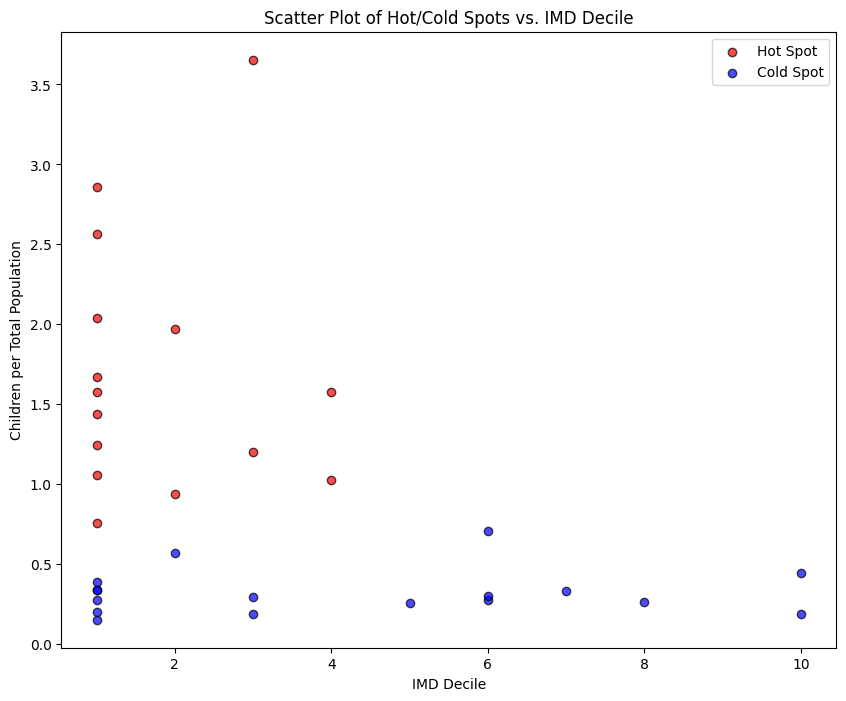

In [39]:
# Define colors for the clusters of interest.
color_map = {"Hot Spot": "red", "Cold Spot": "blue"}

plt.figure(figsize=(10, 8))

# Filter the data to include only hot and cold spots.
scatter_data = hot_cold_merged[hot_cold_merged["cluster"].isin(["Hot Spot", "Cold Spot"])]

# Loop over each cluster type and plot its points.
for cluster, color in color_map.items():
    cluster_subset = scatter_data[scatter_data["cluster"] == cluster]
    plt.scatter(
        cluster_subset["IMD_Decile"],
        cluster_subset["children_per_total_pop"],
        color=color,
        label=cluster,
        edgecolor="k",
        alpha=0.7
    )

plt.xlabel("IMD Decile")
plt.ylabel("Children per Total Population")
plt.title("Scatter Plot of Hot/Cold Spots vs. IMD Decile")
plt.legend()
plt.show()

### How are different categories distributed across areas of varying deprivation levels?

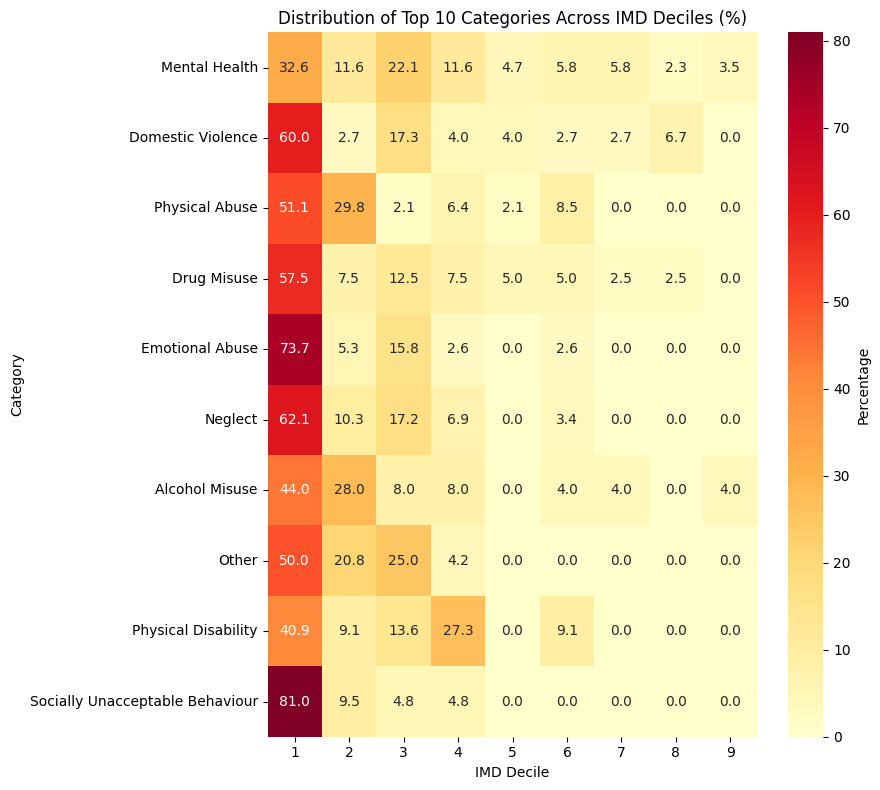

In [40]:
# merged_full = merged_data.merge(
#     imd[['lsoa11cd', 'IMD_Decile']],
#     left_on='lsoa21cd',
#     right_on='lsoa11cd',
#     how='left'
# )

# # Get counts of categories by decile
# category_counts = merged_full.groupby(['Category', 'IMD_Decile']).size().unstack(fill_value=0)

# # Convert IMD_Decile columns to int
# category_counts.columns = category_counts.columns.astype(int)
# category_counts = category_counts.reindex(columns=sorted(category_counts.columns))

# # Get top 10 categories by total count
# top_10_categories = category_counts.sum(axis=1).sort_values(ascending=False).head(10).index

# # Filter for top 10 categories
# category_counts_top10 = category_counts.loc[top_10_categories]

# # Calculate proportions within each Category
# category_proportions_top10 = category_counts_top10.div(category_counts_top10.sum(axis=1), axis=0) * 100

# # Create heatmap
# plt.figure(figsize=(9, 8))
# sns.heatmap(category_proportions_top10, 
#             cmap='YlOrRd', 
#             annot=True, 
#             fmt='.1f',
#             cbar_kws={'label': 'Percentage'})
# plt.title('Distribution of Top 10 Categories Across IMD Deciles (%)')
# plt.xlabel('IMD Decile')
# plt.ylabel('Category')
# plt.tight_layout()

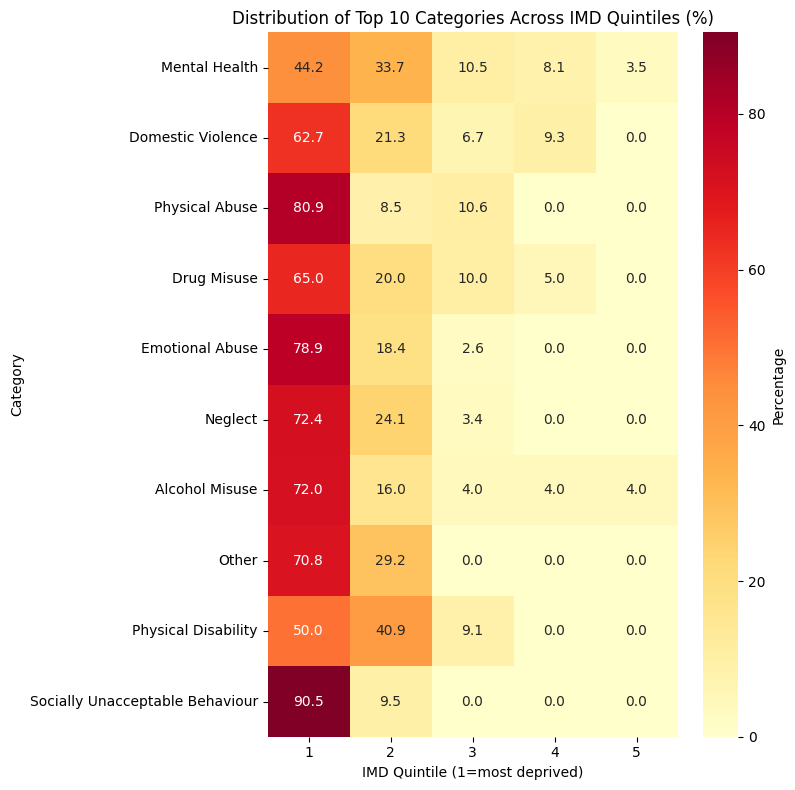

In [41]:
# # Convert deciles to quintiles (1-2 → 1, 3-4 → 2, etc.)
# imd['IMD_Quintile'] = ((imd['IMD_Decile'] - 1) // 2) + 1

# merged_full = merged_data.merge(
#     imd[['lsoa11cd', 'IMD_Quintile']],
#     left_on='lsoa21cd',
#     right_on='lsoa11cd',
#     how='left'
# )

# # Get counts of categories by quintile
# category_counts = merged_full.groupby(['Category', 'IMD_Quintile']).size().unstack(fill_value=0)

# # Convert IMD_Quintile columns to int and sort them
# category_counts.columns = category_counts.columns.astype(int)
# category_counts = category_counts.reindex(columns=sorted(category_counts.columns))

# # Get top 10 categories by total count
# top_10_categories = category_counts.sum(axis=1).sort_values(ascending=False).head(10).index

# # Filter for top 10 categories
# category_counts_top10 = category_counts.loc[top_10_categories]

# # Calculate proportions within each Category
# category_proportions_top10 = category_counts_top10.div(category_counts_top10.sum(axis=1), axis=0) * 100

# # Create heatmap
# plt.figure(figsize=(8, 8))
# sns.heatmap(category_proportions_top10,
#             cmap='YlOrRd',
#             annot=True,
#             fmt='.1f',
#             cbar_kws={'label': 'Percentage'})
# plt.title('Distribution of Top 10 Categories Across IMD Quintiles (%)')
# plt.xlabel('IMD Quintile (1=most deprived)')
# plt.ylabel('Category')
# plt.tight_layout()